# Zero-Shot Learning for Rare Disease Diagnosis## Medical Image Analysis with ZSL

In [35]:
import torch
import torch.nn as nn
import numpy as np
from transformers import BertModel
from sklearn.metrics import top_k_accuracy_score
from matplotlib import pyplot as plt
from transformers import BertTokenizer, BertModel

## 1. Data Preparation

In [36]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

class MedicalDataset:
    def __init__(self):
        # Known diseases (3 classes for demo)
        self.seen_classes = ["Lung Cancer", "Pneumonia", "Tuberculosis"]

        # Rare diseases (2 classes)
        self.unseen_classes = ["Langerhans Cell Histiocytosis", "Lymphangioleiomyomatosis"]

        # Clinical descriptions for all diseases
        self.clinical_texts = {
            "Lung Cancer": "Solitary pulmonary nodule, irregular margins",
            "Pneumonia": "Consolidation in lung, fever and cough",
            "Tuberculosis": "Upper lobe cavitation, night sweats, chronic cough",
            "Langerhans Cell Histiocytosis": "Multiple nodules in upper lung fields, young adults",
            "Lymphangioleiomyomatosis": "Bilateral diffuse cysts, young women"
        }

        # Load tokenizer and model only once
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert.eval()  # disable dropout

        # Generate simulated data
        self.prepare_data()

    def prepare_data(self):
        np.random.seed(42)

        # Training data (known diseases)
        self.X_train = np.random.randn(200, 512)  # CT image features
        self.y_train = np.random.randint(0, len(self.seen_classes), 200)

        # Test data (rare diseases)
        self.X_test = np.random.randn(50, 512)
        self.y_test = np.random.randint(0, len(self.unseen_classes), 50)

        # Get semantic vectors
        self.get_semantic_embeddings()

    def get_semantic_embeddings(self):
        # Get vectors for all diseases
        self.A_seen = np.array([
            self.text_to_vec(self.bert, self.tokenizer, self.clinical_texts[d])
            for d in self.seen_classes
        ])
        self.A_unseen = np.array([
            self.text_to_vec(self.bert, self.tokenizer, self.clinical_texts[d])
            for d in self.unseen_classes
        ])

    def text_to_vec(self, model, tokenizer, text):
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


## 2. ZSL Model

In [37]:
class DiseaseClassifier(nn.Module):
    def __init__(self, img_dim=512, text_dim=768):
        super().__init__()
        self.projector = nn.Sequential(
            nn.Linear(img_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, text_dim)  # Match BERT dimension
        )
    
    def forward(self, x):
        return self.projector(x)

## 3. Training

In [38]:
def train_model(dataset, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = DiseaseClassifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Convert data to tensors
    X = torch.FloatTensor(dataset.X_train).to(device)
    A = torch.FloatTensor(dataset.A_seen).to(device)
    y = torch.LongTensor(dataset.y_train).to(device)
    
    losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Project images to semantic space
        z = model(X)
        
        # Compare with text embeddings
        loss = nn.MSELoss()(z, A[y])
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
    
    return model, losses

## 4. Evaluation

In [39]:
from sklearn.metrics import top_k_accuracy_score

def evaluate(model, dataset):
    device = next(model.parameters()).device

    X_test = torch.FloatTensor(dataset.X_test).to(device)
    A_test = torch.FloatTensor(dataset.A_unseen).to(device)

    model.eval()
    with torch.no_grad():
        Z = model(X_test)
        Z = Z / Z.norm(dim=1, keepdim=True)
        A = A_test / A_test.norm(dim=1, keepdim=True)
        sims = Z @ A.T

    sims_np = sims.cpu().numpy()
    y_true = dataset.y_test

    # Get the number of classes from the similarity matrix
    num_classes = sims_np.shape[1]
    labels = list(range(num_classes))

    # Check if we have a binary classification problem
    if num_classes == 2:
        # For binary classification, you might want different metrics
        y_pred = np.argmax(sims_np, axis=1)
        accuracy = (y_pred == y_true).mean()
        print(f"\nTest Accuracy: {accuracy:.2f}")
    else:
        # For multi-class classification
        top1 = top_k_accuracy_score(y_true, sims_np, k=1, labels=labels)
        top3 = top_k_accuracy_score(y_true, sims_np, k=3, labels=labels)
        print(f"\nTest Accuracy:\nTop-1: {top1:.2f}\nTop-3: {top3:.2f}")

## 5. Main Execution

/Users/qingfengliu/anaconda3/envs/ML_Introduction/lib/python3.12/site-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Dataset: 3 known, 2 rare diseases

Training...
Epoch 5: Loss = 0.0660
Epoch 10: Loss = 0.0286
Epoch 15: Loss = 0.0136
Epoch 20: Loss = 0.0078
Epoch 25: Loss = 0.0051
Epoch 30: Loss = 0.0034
Epoch 35: Loss = 0.0023
Epoch 40: Loss = 0.0017
Epoch 45: Loss = 0.0012
Epoch 50: Loss = 0.0009

Evaluating on rare diseases:

Test Accuracy: 0.56


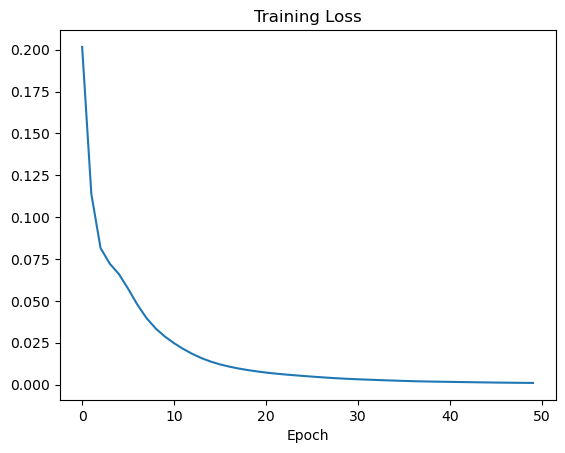

In [40]:
if __name__ == "__main__":
    # Initialize
    data = MedicalDataset()
    print(f"Dataset: {len(data.seen_classes)} known, {len(data.unseen_classes)} rare diseases")
    
    # Train
    print("\nTraining...")
    model, losses = train_model(data)
    
    # Evaluate
    print("\nEvaluating on rare diseases:")
    evaluate(model, data)
    
    # Plot training
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.show()